In [559]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_FOLDER = 'data'

In [560]:
# Load the data
df = pd.read_csv(os.path.join(DATA_FOLDER, '93182_steam_games.csv'))

C:\Users\louis\AppData\Local\Temp\ipykernel_23332\154272785.py:2: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_FOLDER, '93182_steam_games.csv'))


In [561]:
# Only keep the columns we need
NAME = 'name'
GENRES = 'genres'
DESCRIPTION = 'description_raw'
DESCRIPTION_LEMMATIZED = 'description_lemmatized'
DESCRIPTION_STEMMED = 'description_stemmed'
DESCRIPTION_NO_LEMMA_STEM = 'description_no_lemma_stem'

rename_columns = {
    'Name': NAME,
    'Genres': GENRES,
    'About the game': DESCRIPTION,
}

# Rename the columns
df = df.rename(columns=rename_columns)

# Only keep the columns we need
columns = [NAME, GENRES, DESCRIPTION]
df = df[columns]

# Drop rows with missing values
df = df.dropna()

# Drop duplicates of the same game name
df = df.drop_duplicates(subset=NAME)

# Replace special characters the correct way
chars = {
    '’': "'",
    '“': '"',
    '”': '"',
    '‘': "'",
    '’': "'",
    '–': '-',
    '—': '-',
    '…': '...',
}

for char, replacement in chars.items():
    df[DESCRIPTION] = df[DESCRIPTION].str.replace(char, replacement)
    

In [562]:
# Drop the rows with non latin characters
# df = df[df[NAME].str.contains(r'[^\x00-\x7F]+') == False]
df = df[df[DESCRIPTION].str.contains(r'[^\x00-\x7F]+') == False]

# Remove non alphanumeric characters in description with isalnum()
df[DESCRIPTION] = df[DESCRIPTION].apply(lambda x: ''.join([i for i in x if i.isalnum() or i.isspace()]))

# Remove the games with a description length less than 5 words
df = df[df[DESCRIPTION].apply(lambda x: len(x.split()) > 5)]

# Print the length of the dataset
print('Number of games:', len(df))

# Remove the rows containing some given words
words = ['sex', 'sexual content', 'nudity', 'violent', 'gore', 'mature', 'hentai', 'nsfw']
for word in words:
    # Remove the rows containing the word
    df = df[~df[NAME].str.lower().str.contains(word)]
    df = df[~df[GENRES].str.lower().str.contains(word)]
    df = df[~df[DESCRIPTION].str.lower().str.contains(word)]

# Print the length of the dataset
print('Number of games:', len(df))


Number of games: 72041
Number of games: 67998


In [563]:
# Extract the genres into a list
genres = df[GENRES].str.split(',')

# Make a set of all genres
all_genres = set()
for game_genres in genres:
    all_genres.update(game_genres)

print('All genres:', all_genres)
print('Number of genres:', len(all_genres))

All genres: {'Sports', 'Strategy', 'Web Publishing', 'Episodic', 'Adventure', 'Utilities', 'Tutorial', 'Audio Production', '360 Video', 'Massively Multiplayer', 'Education', 'Short', 'Racing', 'Game Development', 'Casual', 'Animation & Modeling', 'RPG', 'Early Access', 'Indie', 'Design & Illustration', 'Photo Editing', 'Movie', 'Software Training', 'Simulation', 'Documentary', 'Video Production', 'Accounting', 'Action', 'Free To Play'}
Number of genres: 29


In [564]:
import re
def clean_genres(text):
    # Replace multiple commas and leading/trailing commas
    cleaned_text = re.sub(r',+|(^,)|(,$)', ',', text)
    # Remove any trailing comma left after cleaning
    return cleaned_text.strip(',')

In [565]:
# Remove the given list of genres from the dataset
genres_to_remove = [
    'Video Production',
    'Utilities',
    'Movie',
    'Documentary',
    'Episodic',
    'Short',
    'Tutorial',
    '360 Video',
    'Software Training',
    'Design & Illustration',
    'Animation & Modeling',
    'Early Access',
    'Audio Production', 
    'Free To Play',
    'Accounting', 
    'Web Publishing',
    'Photo Editing',
    'Game Development',
    'Education',
    'Casual',
    'Indie',
]

# For each row check if the genres contain any of the genres to remove and remove them from the string of genres
for genre in genres_to_remove:
    df[GENRES] = df[GENRES].str.replace(genre, '')
    # Remove commas with regex that are left after removing the genre
    df[GENRES] = df[GENRES].apply(clean_genres)
    
    
# Remove the rows with empty genres
df = df[df[GENRES] != '']

# Print the length of the dataset
print('Number of games:', len(df))

Number of games: 57901


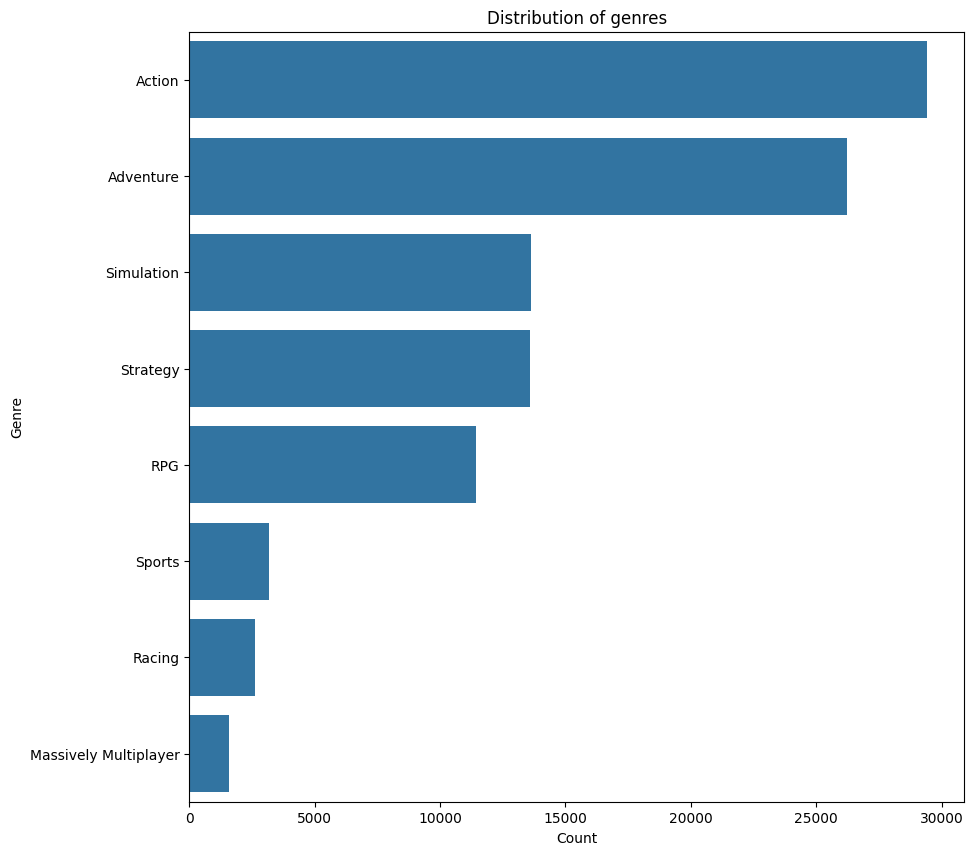

In [566]:
# Plot the distribution of unique genres
genre_counts = df[GENRES].str.split(',').explode().value_counts()
plt.figure(figsize=(10, 10))
sns.barplot(x=genre_counts, y=genre_counts.index)
plt.title('Distribution of genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [567]:
# Remove a game if it has more than 3 genres
df = df[df[GENRES].str.split(',').apply(len) <= 1]

# Duplicate the rows with multiple genres to have one row per genre
# df = df.assign(Genre=df[GENRES].str.split(',')).explode('Genre')

# If a row have multiple genres, create one row for each genre of this game
# df = df.explode(GENRES)

# Plot the distribution of genres by keeping value 
genre_counts = df[GENRES].value_counts()

# Keep only genres with more than 100 games
genre_counts = genre_counts[genre_counts > 100]

# Remove all rows with genres that are less than 100 games
df = df[df[GENRES].isin(genre_counts.index)]

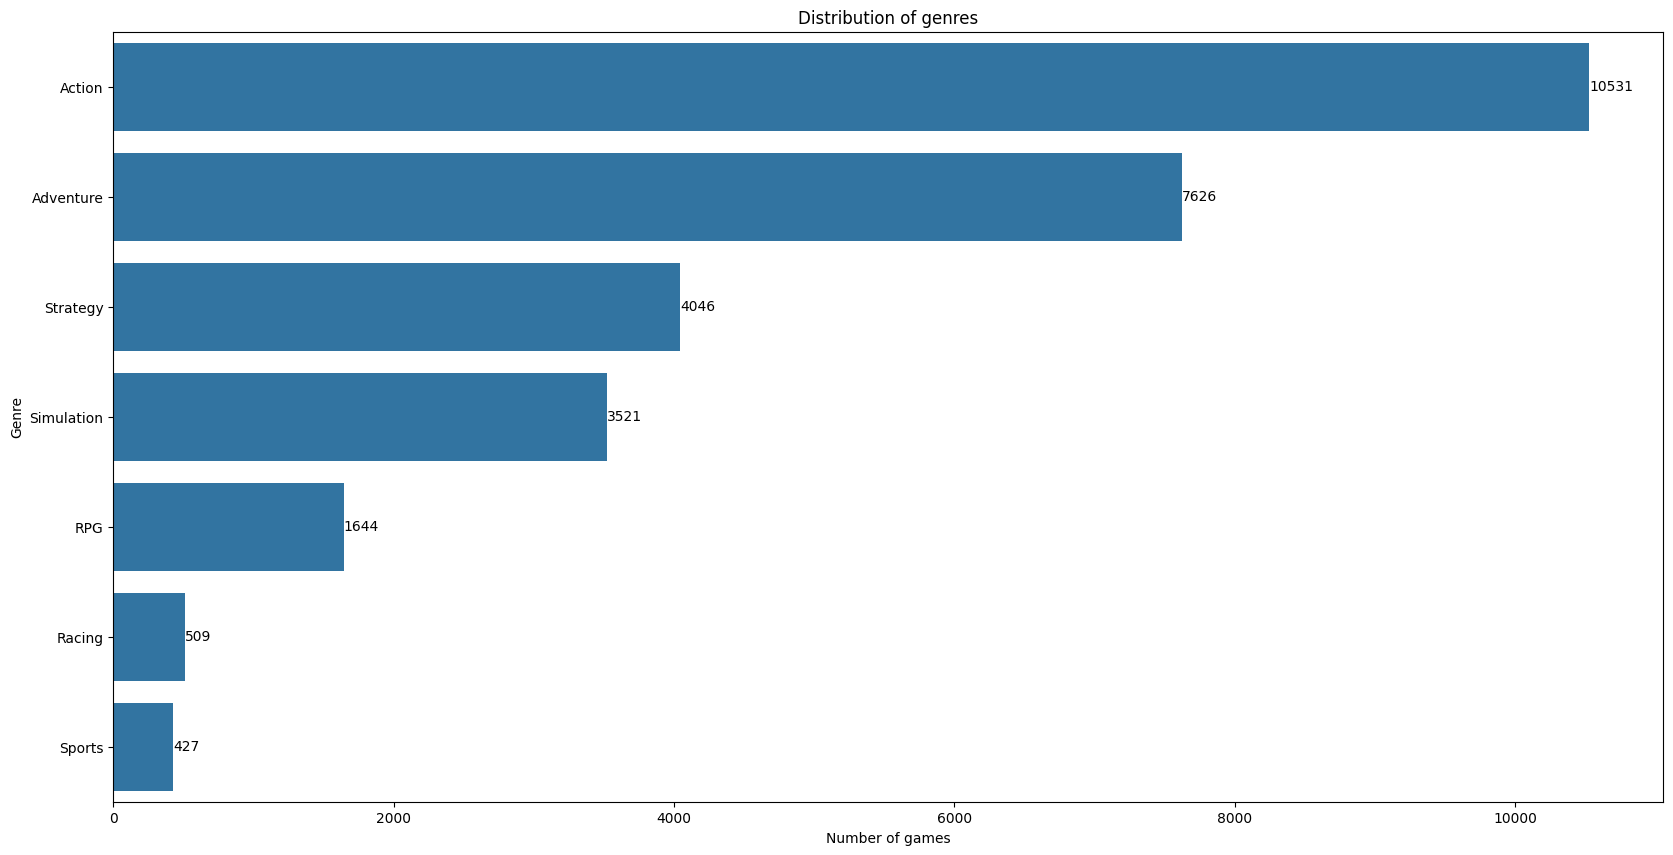

In [568]:
# Print the number next to the genre bars
plt.figure(figsize=(20, 10))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
for i in range(len(genre_counts)):
    # Add the number of games next to the bar centered in the middle according to the bar
    plt.text(genre_counts.values[i], i, genre_counts.values[i], va='center')
plt.title('Distribution of genres')
plt.xlabel('Number of games')
plt.ylabel('Genre')
plt.show()

In [569]:
# Keep the same number of games for each genre
min_genre_count = genre_counts.min()
df = df.groupby(GENRES).apply(lambda x: x.sample(min_genre_count, random_state=42)).reset_index(drop=True)


# Print the length of the dataset
print('Number of games:', len(df))
print('Number of genres:', len(df[GENRES].value_counts()))

Number of games: 2989
Number of genres: 7


In [570]:
# # Compute the average number of tokens in the description
# average_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).mean()
# print('Average description length:', average_description_length)

# # Compute the maximum number of tokens in the description
# max_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).max()
# print('Max description length:', max_description_length)

# # Compute the minimum number of tokens in the description
# min_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).min()
# print('Min description length:', min_description_length)

# # Count the number of games with a description length less than 10
# short_description_games = df[DESCRIPTION].apply(lambda x: len(x.split()) < 10).sum()
# print('Number of games with a description length less than 10:', short_description_games)

In [571]:
# Remove stopwords from the description
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Import the pos tagger
from nltk import pos_tag

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def main_preprocessing(text, words_to_remove: list[str], operation: str=None):
    new_words = []
       
    # Tokenize the description
    words = word_tokenize(text)
    
    for word in words:
        # If the word is a number, skip it
        if word.isdigit():
            continue
        
        # Put all words in lowercase
        word_lower = word.lower()
        
        # Remove stopwords from the description
        if word_lower in stop_words :
            continue
        
        # If we apply lemmatization
        if operation == 'lemmatization':
            # Apply lemmatization to the description
            word_lemma_or_stem = lemmatizer.lemmatize(word_lower)
        
        # If we apply stemming
        elif operation == 'stemming':
            # Apply stemming to the description
            word_lemma_or_stem = stemmer.stem(word_lower)
            
        else:
            # Keep the word as it is (raw)
            word_lemma_or_stem = word_lower
        
        # If a word is in the list of words to remove, skip it
        if word_lemma_or_stem in words_to_remove:
            continue
        
        # If the word is a number, after lemmatization, skip it (e.g. 90s -> 90)
        if word_lemma_or_stem.isdigit():
            continue
        
        # If the word is a single character, skip it
        if len(word_lemma_or_stem) == 1:
            continue
        
        # Remove verbs from the description
        # pos = pos_tag([word_lemma])[0][1]
        # if pos.startswith('VB'):
        #     continue
        
        # Add the word to the new list of words
        new_words.append(word_lemma_or_stem)
    
    return ' '.join(new_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [572]:
# Add all game genres to the stopwords list and lowercase them
words_to_remove = df[GENRES].str.lower().str.split(',').explode().unique().tolist()

# Add some additional words to remove without meaning related to the genre
words_to_remove.extend([
    'game', # Its the most common word in the description for all genres
    'player',
    'play',
    'feature',
    'different',
    'new',
    'one',
])

print('Words to remove:', words_to_remove)
# Apply the main preprocessing function to the description
# Raw description
df[DESCRIPTION] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, []))
# Lemmatized description
df[DESCRIPTION_LEMMATIZED] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove, 'lemmatization'))
# Stemmed description
df[DESCRIPTION_STEMMED] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove, 'stemming'))
# No lemmatization or stemming
df[DESCRIPTION_NO_LEMMA_STEM] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove))

# Create a new column with the the top words in each description
# df['Top words'] = df[DESCRIPTION].apply(lambda x: ' '.join(pd.Series(x.split()).value_counts().index[:10]))

Words to remove: ['action', 'adventure', 'rpg', 'racing', 'simulation', 'sports', 'strategy', 'game', 'player', 'play', 'feature', 'different', 'new', 'one']


In [573]:
# Save the reduced dataset
df.to_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced.csv'), index=False)

In [574]:
# Load the reduced dataset
df_reduced = pd.read_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced.csv'))

In [575]:
# Count the number of each word in the description using Counter
from collections import Counter
 
# Count the number of each word in the description according to the genre
def count_words(column: str, print_most_common: bool=True):
    word_counts = {}
    for genre in df_reduced[GENRES].unique():
        # Get all the descriptions for the genre
        descriptions = df_reduced[df_reduced[GENRES] == genre][column]
        
        # Count the number of each word in the description
        word_count = Counter()
        for description in descriptions:
            words = description.split()
            word_count.update(words)
        
        # Save the word count for the genre
        word_counts[genre] = word_count
        
        if print_most_common:
            # Print the most common words
            print(f"Most common words in column '{column}' for genre: {genre}")
            print(word_count.most_common(10))
        
    return word_counts

In [576]:
# For each word present in the genre add 1 to the variable of unique appearances in genres in a dictionary 
def get_unique_appearances(column, max_print: int=10):
    word_counts = count_words(column)
    
    unique_appearances = {}
    for genre, word_count in word_counts.items():
        for word in word_count.keys():
            # Initialize if word not in dictionary yet
            if word not in unique_appearances:
                unique_appearances[word] = [0, [], []]
            
            # Add 1 to the number of unique appearances
            unique_appearances[word][0] += 1
            
            # Add the count of the word in the current genre
            unique_appearances[word][1].append(word_count[word])
            
    # Express the word count in percentage in the unique appearances
    for word, appearances in unique_appearances.items():
        # Compute the percentage of the word in the genre
        appearances[2] = [round(count / sum(appearances[1]),2) for count in appearances[1]]

            
    # Sort the dictionary by the number of unique appearances and the total number of appearances
    unique_appearances = dict(sorted(unique_appearances.items(), key=lambda x: (x[1][0], sum(x[1][1])), reverse=True))

    # Print the number of unique appearances for each word
    print('Unique appearances of each word in genres:')
    # Header
    print(f'{"Word":15} {"Nb":3} {"Total appearances"} \t {"Percentage in genres"}')
    print('-' * 100)
    idx = 0
    for word, appearances in unique_appearances.items():
        idx += 1
        if idx >= max_print:
            break
        # Pretty print the word and the appearances like a table
        print(f'{word:15} {appearances[0]:3} {appearances[1]} \t {appearances[2]}')
    if len(unique_appearances) > max_print:
        print('...')
        
    return unique_appearances

In [577]:
# Find the words that appear in all genres and the frequency of the word in each genre is relatively equal
def get_words_in_all_genres(unique_appearances, nb_genres: int, boundary: float=0.045):
    words_in_all_genres = []
    middle_boundary = 1/nb_genres
    min_boundary = middle_boundary - boundary
    max_boundary = middle_boundary + boundary

    for word, appearances in unique_appearances.items():
        # If the word appears in all genres and the percentage of the word in the genre is relatively equal depending on the number of genres
        if appearances[0] == nb_genres and all([min_boundary < percentage < max_boundary for percentage in appearances[2]]):
            words_in_all_genres.append(word)
            
    print('Words in all genres:', words_in_all_genres)
    print(f"Number of words in all genres: {len(words_in_all_genres)}, with boundaries: {min_boundary} and {max_boundary}")
    
    return words_in_all_genres

# Remove the words from the text if it is in the list of words to remove
def remove_words(text, words_to_remove):
    words = text.split()
    new_words = [word for word in words if word not in words_to_remove]
    return ' '.join(new_words)

In [578]:
def get_words_to_remove(column: str, nb_genres: int):
    unique_appearances_lemma = get_unique_appearances(column=column)
    print()
    words_in_all_genres_lemma = get_words_in_all_genres(unique_appearances_lemma, nb_genres)
    print()
    return words_in_all_genres_lemma

In [579]:
nb_genres = len(df_reduced[GENRES].unique())

# Remove the words that appear in all genres and the frequency of the word in each genre is relatively equal
# Description lemmatized
words_to_remove_lemma = get_words_to_remove(DESCRIPTION_LEMMATIZED, nb_genres)
df_reduced[DESCRIPTION_LEMMATIZED] = df_reduced[DESCRIPTION_LEMMATIZED].apply(lambda x: remove_words(x, words_to_remove_lemma))

# Description stemmed
words_to_remove_stem = get_words_to_remove(DESCRIPTION_STEMMED, nb_genres)
df_reduced[DESCRIPTION_STEMMED] = df_reduced[DESCRIPTION_STEMMED].apply(lambda x: remove_words(x, words_to_remove_stem))

# Description no lemmatization or stemming
words_to_remove_no_lemma_stem = get_words_to_remove(DESCRIPTION_NO_LEMMA_STEM, nb_genres)
df_reduced[DESCRIPTION_NO_LEMMA_STEM] = df_reduced[DESCRIPTION_NO_LEMMA_STEM].apply(lambda x: remove_words(x, words_to_remove_no_lemma_stem))

Most common words in column 'description_lemmatized' for genre: Action
[('enemy', 390), ('level', 353), ('weapon', 286), ('mode', 252), ('time', 221), ('world', 192), ('get', 187), ('use', 187), ('unique', 169), ('take', 165)]
Most common words in column 'description_lemmatized' for genre: Adventure
[('world', 378), ('puzzle', 359), ('story', 299), ('find', 289), ('level', 205), ('character', 198), ('time', 187), ('explore', 175), ('get', 172), ('way', 171)]
Most common words in column 'description_lemmatized' for genre: RPG
[('world', 454), ('character', 382), ('story', 290), ('battle', 284), ('system', 268), ('find', 214), ('enemy', 210), ('dungeon', 209), ('skill', 200), ('time', 196)]
Most common words in column 'description_lemmatized' for genre: Racing
[('race', 669), ('car', 574), ('track', 520), ('mode', 417), ('time', 322), ('level', 275), ('world', 225), ('get', 203), ('speed', 193), ('vehicle', 189)]
Most common words in column 'description_lemmatized' for genre: Simulation


In [580]:
# Create a word cloud for the most common words in the description
from wordcloud import WordCloud

def plot_word_cloud(column: str, max_words: int=50):
    word_counts = count_words(column=column, print_most_common=False)
    
    # Create a word cloud for each genre
    for genre, word_count in word_counts.items():
        # Convert the most common words to a dictionary (word -> frequency)
        common_words_dict = dict(word_count.most_common(max_words))
        
        wordcloud = WordCloud(width = 800, height = 400, 
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10,
                    max_font_size = 100).generate_from_frequencies(common_words_dict)
        
        plt.figure(figsize = (8, 4), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title(f"Word cloud of '{column}' for genre: {genre}")
        plt.show()

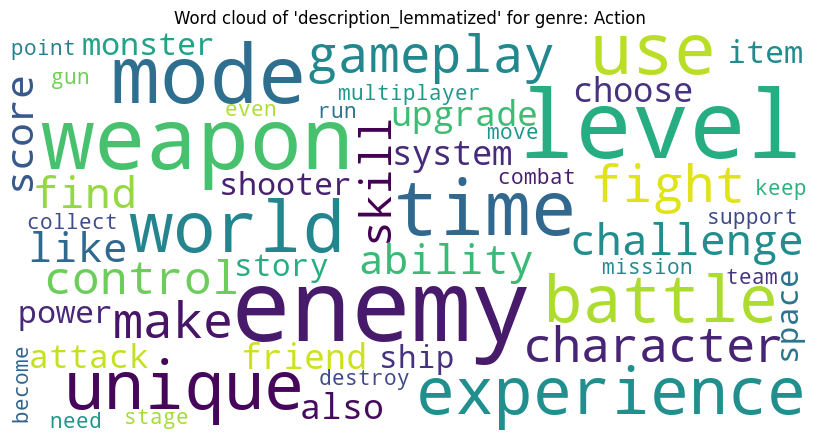

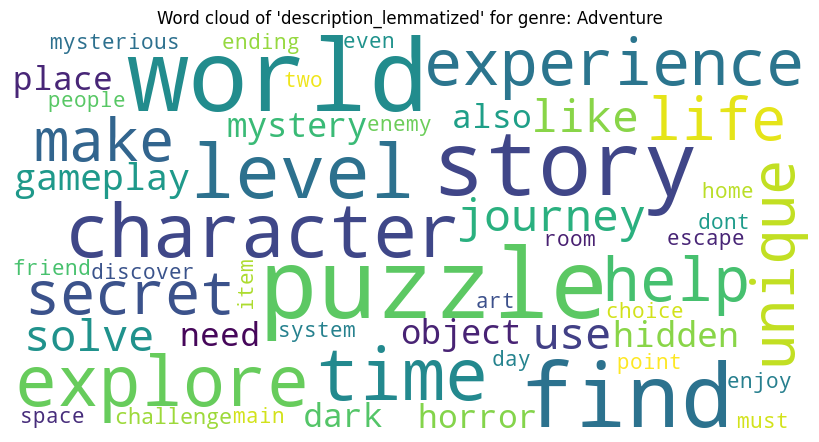

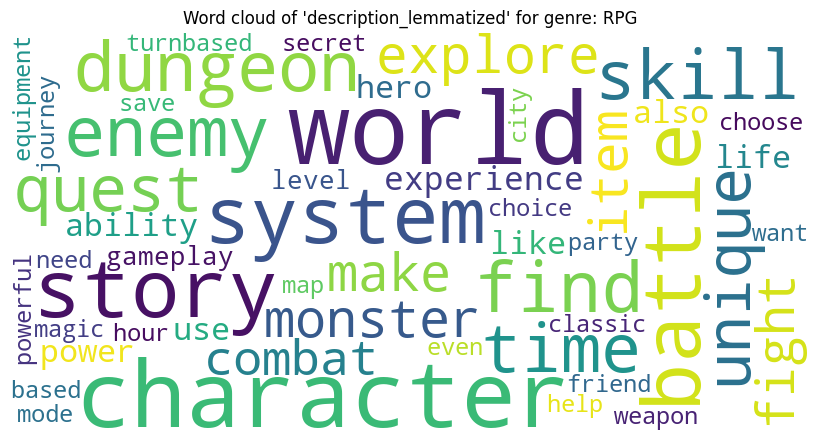

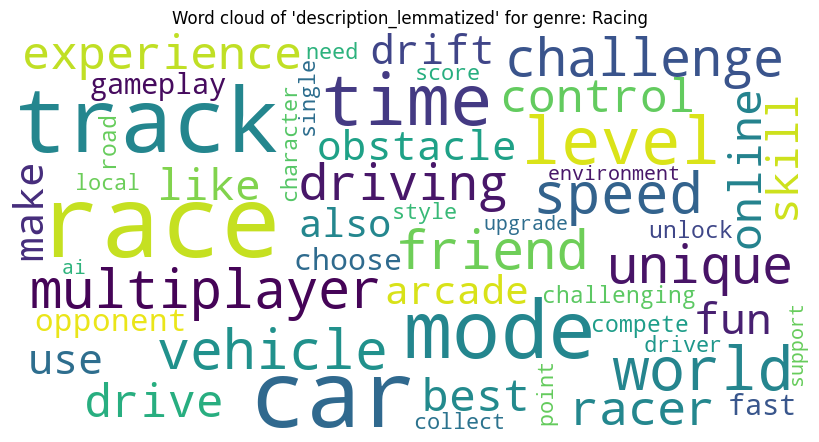

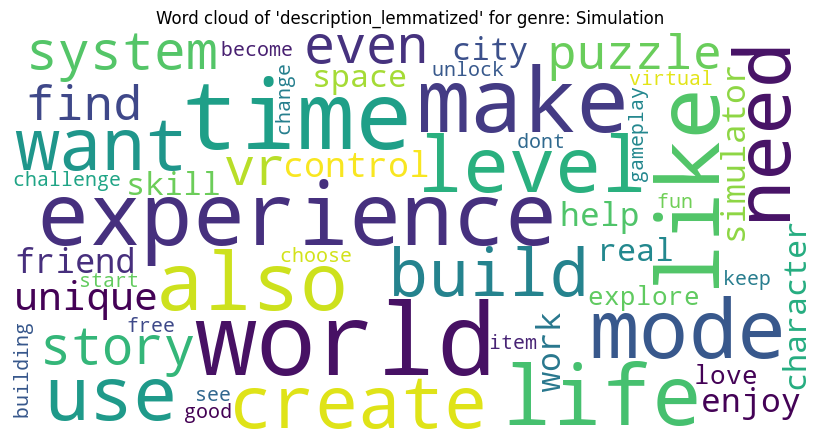

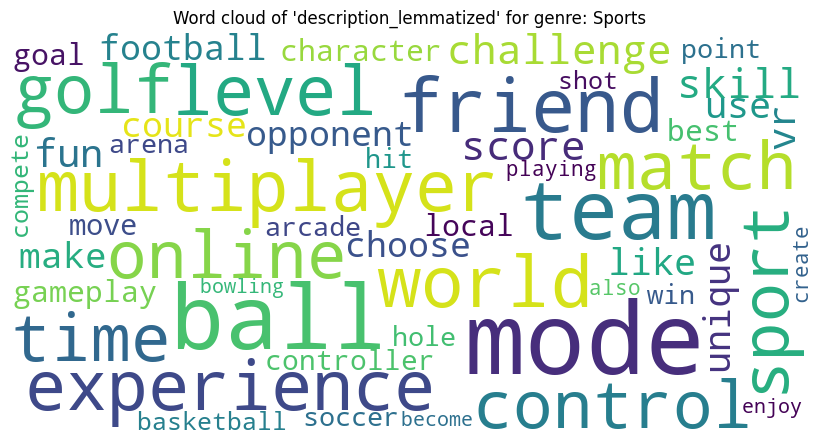

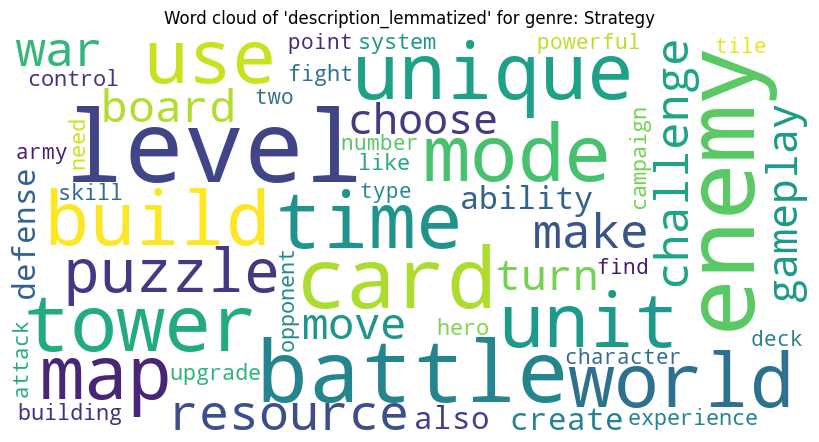

In [581]:
# Plot the word cloud for the lemmatized description
plot_word_cloud(DESCRIPTION_LEMMATIZED)

In [582]:
# Save the reduced dataset
df_reduced.to_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced_2.csv'), index=False)